# Plank Filter

## Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    ToPILImage,
    ToTensor,
)
import torchvision

from tqdm import tqdm


## Load Data

### Dataset Class

In [36]:
"""
Classe pour charger les données.
Les images sont dans le dossier img_dir et les labels dans un fichier csv annotations_file.
Les labels sont des entiers [0,1] qui représentent la présence d'une planche.
"""
class plankFilterDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform=None, target_transform=None
    ):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [37]:
# Pipeline de transformation des images
img_pipeline = Compose(
    [
        ToPILImage(),
        Resize((256, 256)),
        ToTensor(),
    ]
)

# Chargement des données
ds = plankFilterDataset(
    annotations_file=os.path.join("data", "filter_plank_labels.csv"),
    img_dir=os.path.join("subset", "filter_plank"),
    transform=img_pipeline,
)

# Hyperparamètres
batch_size = 4
validation_split = 0.2
shuffle_dataset = True
random_seed = 42
hp = dict(num_epochs=3, learning_rate=0.001, momentum=0.9)


### Train/Test Split

In [38]:
# Creating data indices for training and validation splits

# Calculate size of train and validation dataset
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size

# Train and test split
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

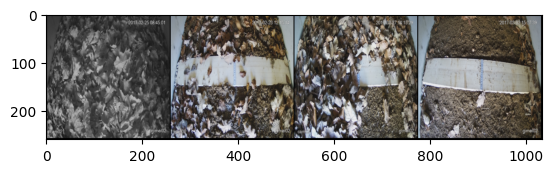

0 1 1 1


In [39]:
# function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
batch = iter(train_loader)
images, labels = next(batch)


# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join(f"{l}" for l in labels))


## Build The Neural Network

We define a convolutionnal neural network with 3 convolutionnal layers and 2 fully connected layers. The output consists of 1 neurons, which is the probability of the image being a plank.


In [40]:
class PlankFilter(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(in_features=128 * 30 * 30, out_features=128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 128 * 30 * 30)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)


In [41]:
# Test if model works
model = PlankFilter()
x = torch.randn(1, 3, 256, 256)
out = model(x)


## Define a Loss function and optimizer

In [42]:
net = PlankFilter()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=hp['learning_rate'])

## Zero the gradients while training the network


In [43]:
for epoch in tqdm(range(hp["num_epochs"])):  # loop over the dataset multiple times

    running_loss = 0.0

    for n_batch, (inputs, labels) in enumerate(train_loader, start=1):
        # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        labels = labels.to(torch.float32).reshape(-1, 1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics every 2000 mini-batches
        running_loss += loss.item()
        if n_batch % 20 == 19: 
            print(
                "epoch/batch [%d, %d] loss: %.3f" % (epoch + 1, n_batch + 1, running_loss / 20)
            )
            running_loss = 0.0

print("Finished Training")


  0%|          | 0/3 [00:00<?, ?it/s]

epoch/batch [1, 20] loss: 0.631
epoch/batch [1, 40] loss: 0.234
epoch/batch [1, 60] loss: 0.137
epoch/batch [1, 80] loss: 0.102
epoch/batch [1, 100] loss: 0.024


 33%|███▎      | 1/3 [00:23<00:47, 23.58s/it]

epoch/batch [2, 20] loss: 0.141
epoch/batch [2, 40] loss: 1.398
epoch/batch [2, 60] loss: 0.094
epoch/batch [2, 80] loss: 0.041
epoch/batch [2, 100] loss: 0.078


 67%|██████▋   | 2/3 [00:47<00:23, 23.61s/it]

epoch/batch [3, 20] loss: 0.331
epoch/batch [3, 40] loss: 0.191
epoch/batch [3, 60] loss: 0.079
epoch/batch [3, 80] loss: 0.096
epoch/batch [3, 100] loss: 0.095


100%|██████████| 3/3 [01:10<00:00, 23.61s/it]

Finished Training


## Model Evaluation



In [44]:
@torch.no_grad()
def test_loop(dataloader, model, loss_fn):
    """
    Batch testing function
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    print("Testing...")

    for X, y in dataloader:
        pred = model(X)
        y = y.to(torch.float32).unsqueeze(1)

        test_loss += loss_fn(pred, y).item()
        correct += (pred.round() == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )


In [45]:
test_loop(test_loader, net, loss_fn)

Testing...
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.063190 



In [46]:
# Standard analysis on the test set
y_true = []
y_pred = []
X_error = []
for X, y in test_dataset:
    y_true.append(y)
    ypp = round(net(X.unsqueeze(0)).item())
    y_pred.append(ypp)
    if ypp != y:
        X_error.append({"X": X, "y": y, "y_pred": ypp})


              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       1.00      0.96      0.98        78

    accuracy                           0.97       100
   macro avg       0.94      0.98      0.96       100
weighted avg       0.97      0.97      0.97       100



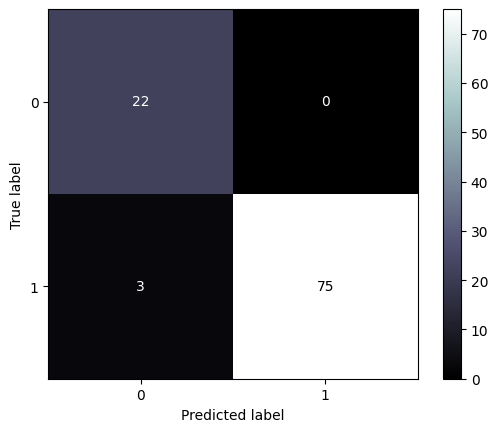

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='bone')

print(classification_report(y_true, y_pred))

True label: 1, prediction: 0


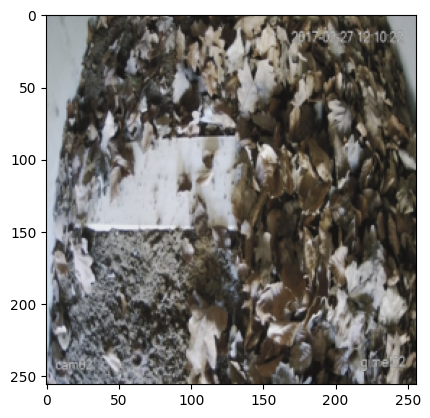

True label: 1, prediction: 0


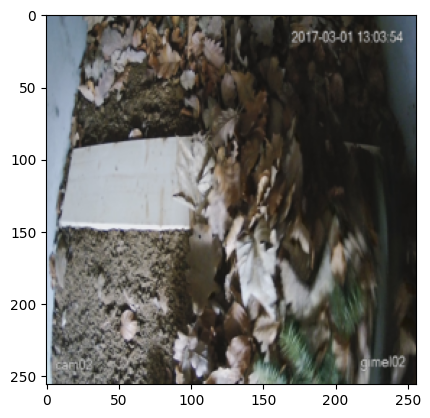

True label: 1, prediction: 0


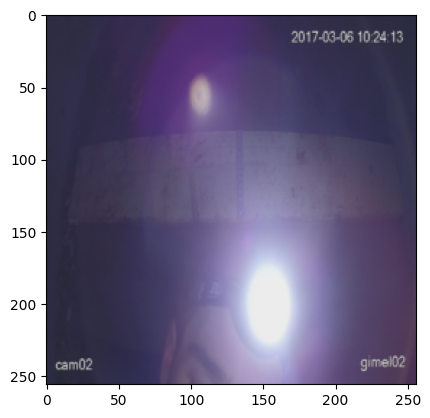

In [48]:
for item in X_error:
    print(f"True label: {item['y']}, prediction: {item['y_pred']}")
    imshow(item["X"])


In [49]:
## Save model
torch.save(net.state_dict(), "plank_filter.pt")